In [50]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time
import math
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import numpy.typing as npt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
SOS_token: int = 0
EOS_token: int = 1

# ===============================
# DATA PREPARATION
# ===============================

class Lang:
    """Language vocabulary class for word-to-index mapping."""

    def __init__(self, name: str) -> None:
        self.name: str = name
        self.word2index: Dict[str, int] = {}
        self.word2count: Dict[str, int] = {}
        self.index2word: Dict[int, str] = {0: "SOS", 1: "EOS"}
        self.n_words: int = 2

    def addSentence(self, sentence: str) -> None:
        """Add all words in a sentence to the vocabulary."""
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word: str) -> None:
        """Add a word to the vocabulary."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def unicodeToAscii(s: str) -> str:
    """Turn a Unicode string to plain ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s: str) -> str:
    """Lowercase, trim, and remove non-letter characters."""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()


def readLangs(lang1: str, lang2: str, reverse: bool = False) -> Tuple[Lang, Lang, List[List[str]]]:
    """Read language pairs from file."""
    print("Reading lines...")

    lines: List[str] = open('/content/drive/MyDrive/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    pairs: List[List[str]] = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang: Lang = Lang(lang2)
        output_lang: Lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
MAX_LENGTH: int = 10

eng_prefixes: Tuple[str, ...] = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p: List[str]) -> bool:
    """Check if a pair meets filtering criteria."""
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs: List[List[str]]) -> List[List[str]]:
    """Filter pairs based on length and prefix criteria."""
    return [pair for pair in pairs if filterPair(pair)]


def prepareData(lang1: str, lang2: str, reverse: bool = False) -> Tuple[Lang, Lang, List[List[str]]]:
    """Prepare data by reading, filtering, and building vocabulary."""
    input_lang: Lang
    output_lang: Lang
    pairs: List[List[str]]
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [10]:
# ===============================
# PRETRAINED EMBEDDINGS
# ===============================

def load_pretrained_embeddings(
    lang: Lang,
    embedding_file: str,
    embedding_dim: int = 300
) -> Optional[torch.Tensor]:
    """
    Load pretrained embeddings (GloVe format).

    Expected format: word dim1 dim2 ... dimN
    Example: the 0.418 0.24968 -0.41242 ...
    """
    embeddings: Dict[str, List[float]] = {}

    try:
        with open(embedding_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word] = vector

        print(f"Loaded {len(embeddings)} word vectors")

        # Create embedding matrix
        embedding_matrix = np.random.randn(lang.n_words, embedding_dim).astype(np.float32)
        embedding_matrix *= 0.01  # Small random initialization

        # Fill in pretrained embeddings
        found = 0
        for word, idx in lang.word2index.items():
            if word in embeddings:
                embedding_matrix[idx] = embeddings[word]
                found += 1

        print(f"Found pretrained embeddings for {found}/{lang.n_words} words")

        return torch.from_numpy(embedding_matrix)

    except FileNotFoundError:
        print(f"Pretrained embeddings file not found: {embedding_file}")
        print("Using random initialization instead")
        return None

In [11]:
# ===============================
# MODEL ARCHITECTURES
# ===============================

class EncoderRNN(nn.Module):
    """Encoder RNN with embedding and GRU."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size: int = hidden_size

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False  # Allow fine-tuning
            )
        else:
            self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru: nn.GRU = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))
        output: torch.Tensor
        hidden: torch.Tensor
        output, hidden = self.gru(embedded)
        return output, hidden

In [12]:
class DeepEncoderRNN(nn.Module):
    """Deep encoder with multiple GRU layers."""

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepEncoderRNN, self).__init__()
        self.hidden_size: int = hidden_size
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(input_size, hidden_size)

        self.gru: nn.GRU = nn.GRU(
            hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))
        output: torch.Tensor
        hidden: torch.Tensor
        output, hidden = self.gru(embedded)
        return output, hidden

In [13]:
class BahdanauAttention(nn.Module):
    """Bahdanau attention mechanism."""

    def __init__(self, hidden_size: int) -> None:
        super(BahdanauAttention, self).__init__()
        self.Wa: nn.Linear = nn.Linear(hidden_size, hidden_size)
        self.Ua: nn.Linear = nn.Linear(hidden_size, hidden_size)
        self.Va: nn.Linear = nn.Linear(hidden_size, 1)

    def forward(self, query: torch.Tensor, keys: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        scores: torch.Tensor = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights: torch.Tensor = F.softmax(scores, dim=-1)
        context: torch.Tensor = torch.bmm(weights, keys)

        return context, weights

In [14]:
class AttnDecoderRNN(nn.Module):
    """Decoder RNN with Bahdanau attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(AttnDecoderRNN, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: BahdanauAttention = BahdanauAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden: torch.Tensor = encoder_hidden
        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        query: torch.Tensor = hidden.permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [15]:
class DeepAttnDecoderRNN(nn.Module):
    """Deep decoder with multiple layers and attention."""

    def __init__(
        self,
        hidden_size: int,
        output_size: int,
        n_layers: int = 2,
        dropout_p: float = 0.1,
        pretrained_embeddings: Optional[torch.Tensor] = None
    ) -> None:
        super(DeepAttnDecoderRNN, self).__init__()
        self.n_layers: int = n_layers

        if pretrained_embeddings is not None:
            self.embedding: nn.Embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                freeze=False
            )
        else:
            self.embedding = nn.Embedding(output_size, hidden_size)

        self.attention: BahdanauAttention = BahdanauAttention(hidden_size)
        self.gru: nn.GRU = nn.GRU(
            2 * hidden_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout_p if n_layers > 1 else 0
        )
        self.out: nn.Linear = nn.Linear(hidden_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(dropout_p)

    def forward(
        self,
        encoder_outputs: torch.Tensor,
        encoder_hidden: torch.Tensor,
        target_tensor: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size: int = encoder_outputs.size(0)
        decoder_input: torch.Tensor = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Expand encoder hidden for multiple layers
        if encoder_hidden.size(0) != self.n_layers:
            decoder_hidden = encoder_hidden.repeat(self.n_layers, 1, 1)
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs: List[torch.Tensor] = []
        attentions: List[torch.Tensor] = []

        for i in range(MAX_LENGTH):
            decoder_output: torch.Tensor
            attn_weights: torch.Tensor
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _: torch.Tensor
                topi: torch.Tensor
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs_cat: torch.Tensor = torch.cat(decoder_outputs, dim=1)
        decoder_outputs_cat = F.log_softmax(decoder_outputs_cat, dim=-1)
        attentions_cat: torch.Tensor = torch.cat(attentions, dim=1)

        return decoder_outputs_cat, decoder_hidden, attentions_cat

    def forward_step(
        self,
        input: torch.Tensor,
        hidden: torch.Tensor,
        encoder_outputs: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        embedded: torch.Tensor = self.dropout(self.embedding(input))

        # Use last layer's hidden state for attention
        query: torch.Tensor = hidden[-1:].permute(1, 0, 2)
        context: torch.Tensor
        attn_weights: torch.Tensor
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru: torch.Tensor = torch.cat((embedded, context), dim=2)

        output: torch.Tensor
        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [16]:
# ===============================
# TRAINING & EVALUATION
# ===============================

def get_dataloader(batch_size: int, lang1: str = 'eng', lang2: str = 'fra', reverse: bool = False) -> Tuple[Lang, Lang, DataLoader]:
    """Create DataLoader for training."""
    input_lang_local: Lang
    output_lang_local: Lang
    pairs_local: List[List[str]]
    input_lang_local, output_lang_local, pairs_local = prepareData(lang1, lang2, reverse=True)

    n: int = len(pairs_local)
    input_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids: npt.NDArray[np.int32] = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs_local):
        inp_ids: List[int] = [input_lang_local.word2index[word] for word in inp.split(' ')]
        tgt_ids: List[int] = [output_lang_local.word2index[word] for word in tgt.split(' ')]
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data: TensorDataset = TensorDataset(
        torch.LongTensor(input_ids).to(device),
        torch.LongTensor(target_ids).to(device)
    )

    train_sampler: RandomSampler = RandomSampler(train_data)
    train_dataloader: DataLoader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang_local, output_lang_local, train_dataloader

In [17]:
def train_epoch(
    dataloader: DataLoader,
    encoder: nn.Module,
    decoder: nn.Module,
    encoder_optimizer: optim.Optimizer,
    decoder_optimizer: optim.Optimizer,
    criterion: nn.Module
) -> float:
    """Train for one epoch."""
    total_loss: float = 0.0
    for data in dataloader:
        input_tensor: torch.Tensor
        target_tensor: torch.Tensor
        input_tensor, target_tensor = data

        if encoder_optimizer:
            encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs: torch.Tensor
        encoder_hidden: torch.Tensor
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs: torch.Tensor
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss: torch.Tensor = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        # Gradient clipping
        if encoder_optimizer:
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            encoder_optimizer.step()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [21]:
def train(
    train_dataloader: DataLoader,
    encoder: nn.Module,
    decoder: nn.Module,
    n_epochs: int,
    learning_rate: float = 0.001,
    print_every: int = 10,
    train_encoder: bool = True
) -> List[float]:
    """Train the model."""
    start: float = time.time()
    losses: List[float] = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate) if train_encoder else None
    decoder_optimizer: optim.Adam = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion: nn.NLLLoss = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss: float = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        losses.append(loss)

        if epoch % print_every == 0:
            elapsed = time.time() - start
            print(f'Epoch {epoch}/{n_epochs} ({epoch/n_epochs*100:.0f}%) - Loss: {loss:.4f} - Time: {elapsed:.0f}s')

    return losses


def evaluate(
    encoder: nn.Module,
    decoder: nn.Module,
    sentence: str,
    input_lang: Lang,
    output_lang: Lang
) -> Tuple[List[str], Optional[torch.Tensor]]:
    """Evaluate a single sentence."""
    with torch.no_grad():
        indexes: List[int] = [input_lang.word2index[word] for word in sentence.split(' ') if word in input_lang.word2index]
        indexes.append(EOS_token)
        input_tensor: torch.Tensor = torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

        encoder_outputs: torch.Tensor
        encoder_hidden: torch.Tensor
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs: torch.Tensor
        decoder_attn: Optional[torch.Tensor]
        decoder_outputs, _, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _: torch.Tensor
        topi: torch.Tensor
        _, topi = decoder_outputs.topk(1)
        decoded_ids: torch.Tensor = topi.squeeze()

        decoded_words: List[str] = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])

    return decoded_words, decoder_attn

In [19]:
def evaluate_bleu(
    encoder: nn.Module,
    decoder: nn.Module,
    pairs: List[List[str]],
    input_lang: Lang,
    output_lang: Lang,
    n: int = 100
) -> float:
    total_bleu = 0.0
    for _ in range(n):
        pair = random.choice(pairs)
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        reference = [pair[1].split()]
        candidate = output_words[:-1]  # Remove <EOS>
        total_bleu += sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    return total_bleu / n

In [22]:
# ===============================
# EXPERIMENTS
# ===============================

print("\n" + "="*70)
print("EXPERIMENT 1: Baseline (Original Architecture)")
print("="*70)

input_lang, output_lang, train_dataloader = get_dataloader(32)

encoder1 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder1 = AttnDecoderRNN(128, output_lang.n_words).to(device)

losses1 = train(train_dataloader, encoder1, decoder1, 50, learning_rate=0.001, print_every=10)

encoder1.eval()
decoder1.eval()

# Test
test_sentences = [
    'je suis trop fatigue',
    'il est tres grand',
    'elle est belle'
]

print("\nTest Results (Baseline):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder1, decoder1, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 1: Baseline (Original Architecture)
Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
Epoch 10/50 (20%) - Loss: 0.5005 - Time: 95s
Epoch 20/50 (40%) - Loss: 0.1525 - Time: 184s
Epoch 30/50 (60%) - Loss: 0.0739 - Time: 273s
Epoch 40/50 (80%) - Loss: 0.0496 - Time: 362s
Epoch 50/50 (100%) - Loss: 0.0406 - Time: 451s

Test Results (Baseline):
  je suis trop fatigue -> i m too tired of tired <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she s smart enough <EOS>


In [23]:
print("\n" + "="*70)
print("EXPERIMENT 2: Deeper Network (2 layers)")
print("="*70)

encoder2 = DeepEncoderRNN(input_lang.n_words, 128, n_layers=2).to(device)
decoder2 = DeepAttnDecoderRNN(128, output_lang.n_words, n_layers=2).to(device)

losses2 = train(train_dataloader, encoder2, decoder2, 50, learning_rate=0.001, print_every=10)

encoder2.eval()
decoder2.eval()

print("\nTest Results (Deep Network):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder2, decoder2, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 2: Deeper Network (2 layers)
Epoch 10/50 (20%) - Loss: 0.7309 - Time: 104s
Epoch 20/50 (40%) - Loss: 0.3181 - Time: 208s
Epoch 30/50 (60%) - Loss: 0.1664 - Time: 311s
Epoch 40/50 (80%) - Loss: 0.1015 - Time: 414s
Epoch 50/50 (100%) - Loss: 0.0758 - Time: 518s

Test Results (Deep Network):
  je suis trop fatigue -> i am too tired tired <EOS>
  il est tres grand -> he is very strict <EOS>
  elle est belle -> beautiful beautiful beautiful than him happy <EOS>


In [24]:
print("\n" + "="*70)
print("EXPERIMENT 3: Larger Hidden Size (256)")
print("="*70)

encoder3 = EncoderRNN(input_lang.n_words, 256).to(device)
decoder3 = AttnDecoderRNN(256, output_lang.n_words).to(device)

losses3 = train(train_dataloader, encoder3, decoder3, 50, learning_rate=0.001, print_every=10)

encoder3.eval()
decoder3.eval()

print("\nTest Results (Larger Hidden):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder3, decoder3, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 3: Larger Hidden Size (256)
Epoch 10/50 (20%) - Loss: 0.1072 - Time: 92s
Epoch 20/50 (40%) - Loss: 0.0431 - Time: 182s
Epoch 30/50 (60%) - Loss: 0.0350 - Time: 273s
Epoch 40/50 (80%) - Loss: 0.0303 - Time: 364s
Epoch 50/50 (100%) - Loss: 0.0291 - Time: 455s

Test Results (Larger Hidden):
  je suis trop fatigue -> i am too tired <EOS>
  il est tres grand -> he is very tall <EOS>
  elle est belle -> she is beautiful <EOS>


In [25]:
print("\n" + "="*70)
print("EXPERIMENT 4: More Training Epochs (100)")
print("="*70)

encoder4 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder4 = AttnDecoderRNN(128, output_lang.n_words).to(device)

losses4 = train(train_dataloader, encoder4, decoder4, 100, learning_rate=0.001, print_every=20)

encoder4.eval()
decoder4.eval()

print("\nTest Results (More Epochs):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder4, decoder4, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 4: More Training Epochs (100)
Epoch 20/100 (20%) - Loss: 0.1463 - Time: 178s
Epoch 40/100 (40%) - Loss: 0.0498 - Time: 358s
Epoch 60/100 (60%) - Loss: 0.0337 - Time: 535s
Epoch 80/100 (80%) - Loss: 0.0295 - Time: 712s
Epoch 100/100 (100%) - Loss: 0.0260 - Time: 889s

Test Results (More Epochs):
  je suis trop fatigue -> i m too tired to tired <EOS>
  il est tres grand -> he is very tall as tall <EOS>
  elle est belle -> she is beautiful beautiful <EOS>


In [ ]:
# Add Word2Vec loading support
from gensim.models import KeyedVectors

def load_word2vec_embeddings(lang: Lang, embedding_file: str, embedding_dim: int = 300) -> Optional[torch.Tensor]:
    try:
        model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
        print(f"Loaded Word2Vec model with {len(model.key_to_index)} vectors")

        embedding_matrix = np.random.randn(lang.n_words, embedding_dim).astype(np.float32) * 0.01
        found = 0
        for word, idx in lang.word2index.items():
            if word in model:
                embedding_matrix[idx] = model[word]
                found += 1

        print(f"Found Word2Vec embeddings for {found}/{lang.n_words} words")
        return torch.from_numpy(embedding_matrix)
    except FileNotFoundError:
        print(f"Word2Vec file not found: {embedding_file}")
        return None

# Update experiment code
print("\n" + "="*70)
print("EXPERIMENT 5: Pretrained GloVe Embeddings")
print("="*70)

# Load GloVe embeddings (adjust path to your GloVe file)
input_embeddings = load_pretrained_embeddings(input_lang, 'glove.6B.300d.txt', 128)
output_embeddings = load_pretrained_embeddings(output_lang, 'glove.6B.300d.txt', 128)

encoder5 = EncoderRNN(input_lang.n_words, 128, pretrained_embeddings=input_embeddings).to(device)
decoder5 = AttnDecoderRNN(128, output_lang.n_words, pretrained_embeddings=output_embeddings).to(device)

losses5 = train(train_dataloader, encoder5, decoder5, 50, learning_rate=0.001, print_every=10)

encoder5.eval()
decoder5.eval()

print("\nTest Results (GloVe Embeddings):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder5, decoder5, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")

In [26]:
# Relax filtering
def filterPair_2(p: List[str]) -> bool:
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Experiment 6: More Sentences
print("\n" + "="*70)
print("EXPERIMENT 6: More Sentences")
print("="*70)

input_lang, output_lang, train_dataloader = get_dataloader(32)  # Larger dataset due to relaxed filter

encoder6 = EncoderRNN(input_lang.n_words, 128).to(device)
decoder6 = AttnDecoderRNN(128, output_lang.n_words).to(device)

start_time = time.time()
losses6 = train(train_dataloader, encoder6, decoder6, 50, learning_rate=0.001, print_every=10)
training_time = time.time() - start_time

encoder6.eval()
decoder6.eval()

print(f"\nTraining Time: {training_time:.0f} seconds")
print("\nTest Results (More Sentences):")
for sentence in test_sentences:
    output_words, _ = evaluate(encoder6, decoder6, sentence, input_lang, output_lang)
    print(f"  {sentence} -> {' '.join(output_words)}")


EXPERIMENT 6: More Sentences
Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
Epoch 10/50 (20%) - Loss: 0.4748 - Time: 89s
Epoch 20/50 (40%) - Loss: 0.1415 - Time: 177s
Epoch 30/50 (60%) - Loss: 0.0676 - Time: 266s
Epoch 40/50 (80%) - Loss: 0.0458 - Time: 355s
Epoch 50/50 (100%) - Loss: 0.0384 - Time: 444s

Training Time: 444 seconds

Test Results (More Sentences):
  je suis trop fatigue -> i am too tired <EOS>
  il est tres grand -> he very tall <EOS>
  elle est belle -> she is beautiful beautiful <EOS>


In [28]:
# ===============================
# COMPARISON
# ===============================

print("\n" + "="*70)
print("RESULTS COMPARISON")
print("="*70)

print("\nFinal Losses:")
print(f"  Baseline:     {losses1[-1]:.4f}")
print(f"  Deep Network: {losses2[-1]:.4f}")
print(f"  Large Hidden: {losses3[-1]:.4f}")
print(f"  More Epochs:  {losses4[-1]:.4f}")
print(f"  More Sentences:  {losses6[-1]:.4f}")



RESULTS COMPARISON

Final Losses:
  Baseline:     0.0406
  Deep Network: 0.0758
  Large Hidden: 0.0291
  More Epochs:  0.0260
  More Sentences:  0.0384


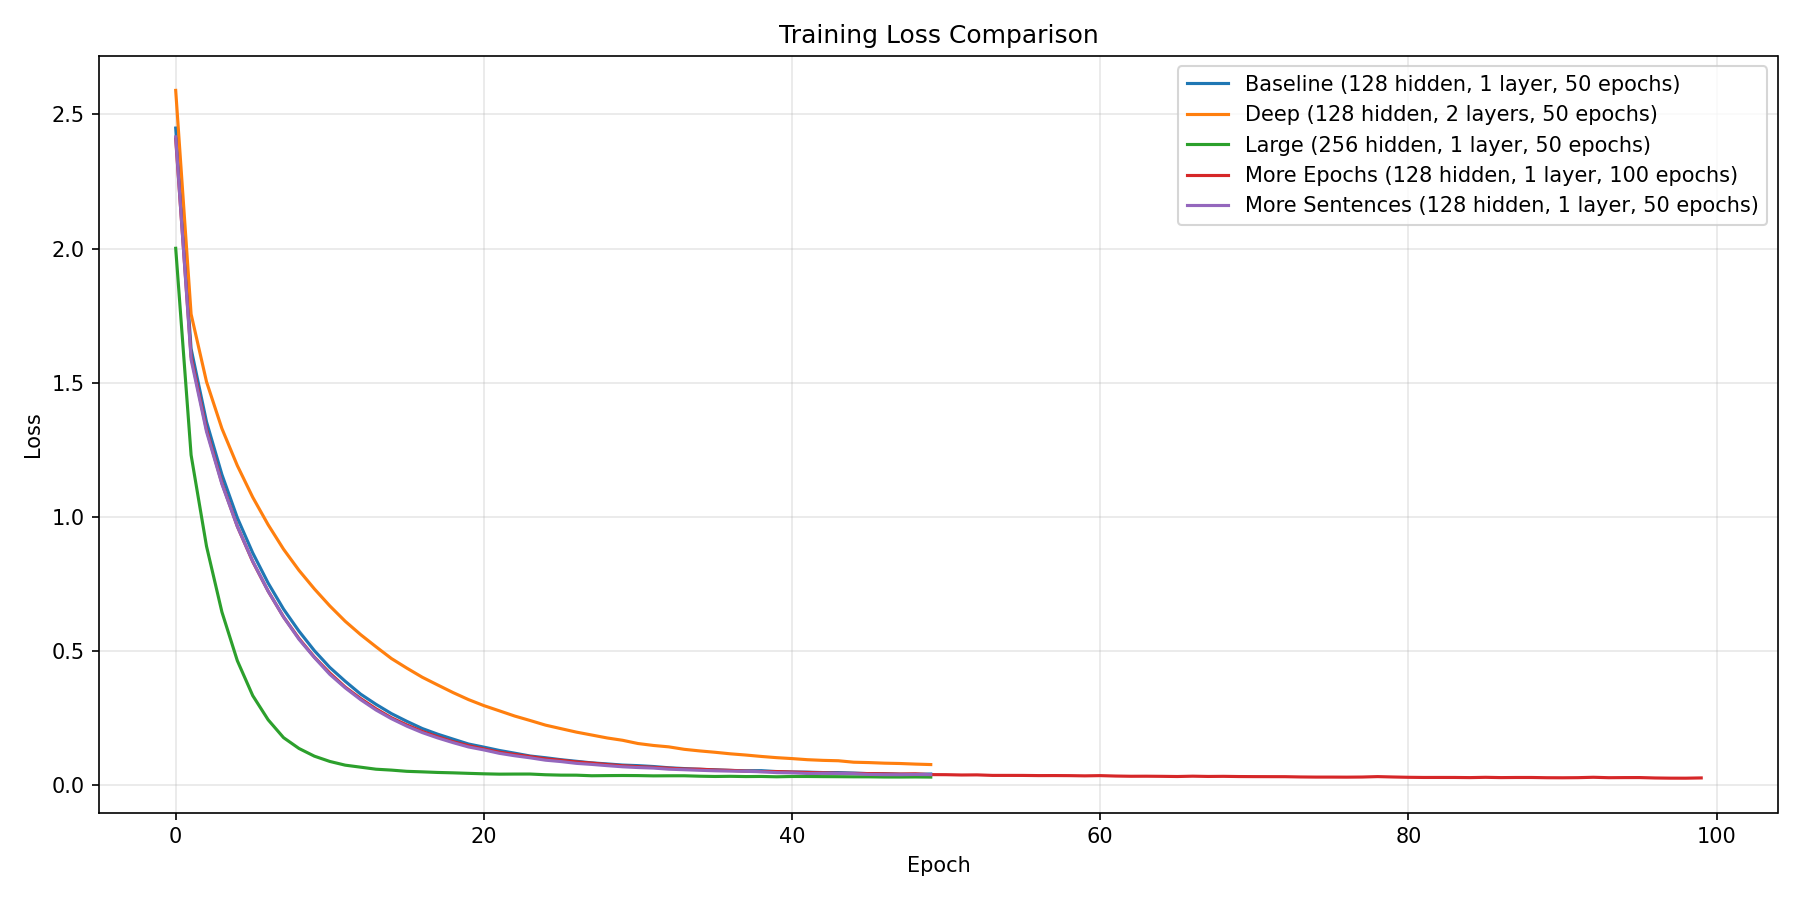

In [51]:
# plt.figure(figsize=(12, 6))
# plt.plot(losses1, label='Baseline (128 hidden, 1 layer, 50 epochs)')
# plt.plot(losses2, label='Deep (128 hidden, 2 layers, 50 epochs)')
# plt.plot(losses3, label='Large (256 hidden, 1 layer, 50 epochs)')
# plt.plot(losses4, label='More Epochs (128 hidden, 1 layer, 100 epochs)')
# # plt.plot(losses5, label='Pretrained GloVe Embeddings (128 hidden, 1 layer, 50 epochs)')
# plt.plot(losses6, label='More Sentences (128 hidden, 1 layer, 50 epochs)')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Comparison')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()
# plt.savefig('comparison.png', dpi=150)

import matplotlib.pyplot as plt
from IPython.display import Image, display

plt.figure(figsize=(12, 6))
plt.plot(losses1, label='Baseline (128 hidden, 1 layer, 50 epochs)')
plt.plot(losses2, label='Deep (128 hidden, 2 layers, 50 epochs)')
plt.plot(losses3, label='Large (256 hidden, 1 layer, 50 epochs)')
plt.plot(losses4, label='More Epochs (128 hidden, 1 layer, 100 epochs)')
plt.plot(losses6, label='More Sentences (128 hidden, 1 layer, 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('comparison.png', dpi=150)
plt.show()
display(Image(filename='comparison.png'))



In [42]:
!pip install nltk pandas
!python -c "import nltk; nltk.download('punkt')"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [61]:
# ===============================
# DEBUG SETUP
# ===============================
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Synchronous CUDA errors
os.environ['TORCH_USE_CUDA_DSA'] = '1'    # Device-side asserts

# ===============================
# ИСПРАВЛЕННЫЙ АВТОЭНКОДЕР
# ===============================
print("\n" + "="*70)
print("AUTOENCODER EXPERIMENT (FIXED)")
print("="*70)
print("Creating autoencoder dataset (input = output)...")

# Load dataset
input_lang, output_lang, pairs = prepareData('eng', 'fra', True, filter_pairs=True)
print("Sample auto_pairs:", [[p[0], p[0]] for p in pairs[:5]])  # Debug: print first 5 pairs

# Use all French sentences
auto_pairs = [[p[0], p[0]] for p in pairs]

# Initialize auto_lang with UNK token
auto_lang = Lang('auto')
auto_lang.word2index = input_lang.word2index.copy()
auto_lang.index2word = input_lang.index2word.copy()
auto_lang.word2count = input_lang.word2count.copy()
auto_lang.n_words = input_lang.n_words

# Add <UNK> token
UNK_token = 2
auto_lang.word2index['<UNK>'] = UNK_token
auto_lang.index2word[UNK_token] = '<UNK>'
auto_lang.n_words += 1

print(f"Autoencoder vocab size: {auto_lang.n_words}")  # Should be 4602

# Create autoencoder dataloader with robust checks
n = len(auto_pairs)
auto_input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
auto_target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

for idx, (inp, tgt) in enumerate(auto_pairs):
    # Skip empty or malformed sentences
    if not inp.strip() or not tgt.strip():
        print(f"Warning: Skipping empty sentence at index {idx}: {inp}")
        inp_ids = [SOS_token, EOS_token]
        tgt_ids = [SOS_token, EOS_token]
    else:
        # Normalize and tokenize
        inp = normalizeString(inp)  # Re-normalize to be safe
        tgt = normalizeString(tgt)
        inp_words = inp.split(' ')
        tgt_words = tgt.split(' ')
        if not inp_words or not tgt_words:  # Check for empty tokenization
            print(f"Warning: Empty tokenization at index {idx}: {inp}")
            inp_ids = [SOS_token, EOS_token]
            tgt_ids = [SOS_token, EOS_token]
        else:
            inp_ids = [auto_lang.word2index.get(word, UNK_token) for word in inp_words]
            tgt_ids = [auto_lang.word2index.get(word, UNK_token) for word in tgt_words]

    # Append EOS
    inp_ids.append(EOS_token)
    tgt_ids.append(EOS_token)

    # Truncate first, then pad
    inp_ids = inp_ids[:MAX_LENGTH-1]  # Leave room for EOS
    tgt_ids = tgt_ids[:MAX_LENGTH-1]

    # Pad with 0 (SOS_token)
    while len(inp_ids) < MAX_LENGTH:
        inp_ids.append(0)
    while len(tgt_ids) < MAX_LENGTH:
        tgt_ids.append(0)

    # Validate indices
    if max(inp_ids) >= auto_lang.n_words or min(inp_ids) < 0:
        print(f"Error: Invalid input indices at {idx}: {inp_ids} for sentence: {inp}")
    if max(tgt_ids) >= auto_lang.n_words or min(tgt_ids) < 0:
        print(f"Error: Invalid target indices at {idx}: {tgt_ids} for sentence: {tgt}")

    auto_input_ids[idx] = inp_ids
    auto_target_ids[idx] = tgt_ids

# Debug: Check indices
print(f"Max index in input_ids: {np.max(auto_input_ids)}")
print(f"Min index in input_ids: {np.min(auto_input_ids)}")
print(f"Sample input_ids[0]: {auto_input_ids[0]}")
assert np.max(auto_input_ids) < auto_lang.n_words, "Out-of-bounds indices in input_ids"
assert np.max(auto_target_ids) < auto_lang.n_words, "Out-of-bounds indices in target_ids"
assert np.min(auto_input_ids) >= 0, "Negative indices in input_ids"
assert np.min(auto_target_ids) >= 0, "Negative indices in target_ids"

# Try on CPU first to isolate CUDA issue
device = torch.device("cuda")  # Switch to CPU for debugging
print(f"Using device: {device}")

auto_data = TensorDataset(
    torch.LongTensor(auto_input_ids),
    torch.LongTensor(auto_target_ids)
)
auto_dataloader = DataLoader(auto_data, batch_size=32, shuffle=True)

# Train autoencoder
print("Training autoencoder...")
start_time = time.time()
auto_encoder = EncoderRNN(auto_lang.n_words, 128)
auto_decoder = AttnDecoderRNN(128, auto_lang.n_words)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(self.max_length):
            # Debug: Check decoder_input indices
            if decoder_input.max().item() >= self.output_size or decoder_input.min().item() < 0:
                print(f"Invalid decoder_input at step {i}: {decoder_input}")

            embedded = self.embedding(decoder_input)
            attn_weights = F.softmax(self.attn(torch.cat((embedded.squeeze(1), decoder_hidden.squeeze(0)), dim=1)), dim=1)
            attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
            output = torch.cat((embedded.squeeze(1), attn_applied.squeeze(1)), dim=1)
            output = self.attn_combine(output)
            output = F.relu(output)
            output, decoder_hidden = self.gru(output.unsqueeze(1), decoder_hidden)
            output = self.out(output.squeeze(1))
            decoder_outputs.append(output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)  # Teacher forcing
            else:
                _, topi = output.topk(1)
                decoder_input = topi.detach()

        decoder_outputs = torch.stack(decoder_outputs, dim=1)
        return decoder_outputs, decoder_hidden, attn_weights

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0.0
    for data in dataloader:
        input_tensor, target_tensor = data
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # Debug: Check indices
        if input_tensor.max().item() >= auto_lang.n_words or input_tensor.min().item() < 0:
            print(f"Invalid input indices in batch: {input_tensor}")
        if target_tensor.max().item() >= auto_lang.n_words or target_tensor.min().item() < 0:
            print(f"Invalid target indices in batch: {target_tensor}")

        if encoder_optimizer:
            encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        if encoder_optimizer:
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
            encoder_optimizer.step()
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=10, train_encoder=True):
    losses = []
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate) if train_encoder else None
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        losses.append(loss)
        if epoch % print_every == 0:
            print(f'Epoch {epoch}/{n_epochs} ({epoch/n_epochs*100:.0f}%) - Loss: {loss:.4f}')

    return losses

auto_losses = train(auto_dataloader, auto_encoder, auto_decoder, 50, learning_rate=0.001, print_every=10)

auto_time = time.time() - start_time
print(f"Autoencoder training time: {auto_time:.0f}s")
torch.save(auto_encoder.state_dict(), 'auto_encoder.pth')
print("Saved autoencoder encoder to 'auto_encoder.pth'")

# Evaluate autoencoder
auto_encoder.eval()
auto_decoder.eval()
print("\nAutoencoder Test Results:")
test_sentences = [
    'je suis trop fatigue',
    'il est tres grand',
    'elle est belle',
    'tu es content',
    'nous sommes amis'
]
auto_reconstructions = []
for sentence in test_sentences:
    indexes = [auto_lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]
    if any(idx == UNK_token for word, idx in zip(sentence.split(' '), indexes) if word not in auto_lang.word2index):
        auto_reconstructions.append("[Skipped: Unknown words]")
        print(f"  {sentence} -> [Skipped: Unknown words]")
    else:
        output_words, _ = evaluate(auto_encoder, auto_decoder, sentence, auto_lang, auto_lang)
        recon = ' '.join(output_words)
        auto_reconstructions.append(recon)
        print(f"  {sentence} -> {recon}")

# ===============================
# ✅ TRANSLATION (Совпадающие vocabs)
# ===============================

print("\n" + "="*70)
print("TRANSLATION EXPERIMENT WITH PRETRAINED ENCODER")
print("="*70)

# ✅ dataloader с ТЕМ ЖЕ input_lang
_, _, train_dataloader = get_dataloader(32, 'eng', 'fra', True)  # Уже есть выше

# ✅ Encoder с ТЕМ ЖЕ размером (4601)
translation_encoder = EncoderRNN(input_lang.n_words, 128).to(device)  # ✅ input_lang.n_words
translation_encoder.load_state_dict(torch.load('auto_encoder.pth'))
translation_encoder.eval()

translation_decoder = AttnDecoderRNN(128, output_lang.n_words).to(device)

# Train decoder only
start_time = time.time()
print("Training new decoder...")
trans_losses = train(train_dataloader, translation_encoder, translation_decoder, 50, learning_rate=0.001, print_every=10, train_encoder=False)
trans_time = time.time() - start_time
print(f"Decoder training time: {trans_time:.0f}s")

translation_decoder.eval()

print("\nTranslation Test Results:")
trans_outputs = []
for sentence in test_sentences:
    output_words, _ = evaluate(translation_encoder, translation_decoder, sentence, input_lang, output_lang)
    trans = ' '.join(output_words)
    trans_outputs.append(trans)
    print(f"  {sentence} -> {trans}")

bleu_score = evaluate_bleu(translation_encoder, translation_decoder, pairs, input_lang, output_lang, n=100)
print(f"\nBLEU Score (Translation): {bleu_score:.4f}")

# ===============================
# BASELINE
# ===============================

print("\n" + "="*70)
print("BASELINE EXPERIMENT")
print("="*70)

start_time = time.time()
baseline_encoder = EncoderRNN(input_lang.n_words, 128).to(device)
baseline_decoder = AttnDecoderRNN(128, output_lang.n_words).to(device)
baseline_losses = train(train_dataloader, baseline_encoder, baseline_decoder, 50, learning_rate=0.001, print_every=10)
baseline_time = time.time() - start_time
print(f"Baseline training time: {baseline_time:.0f}s")

baseline_encoder.eval()
baseline_decoder.eval()

print("\nBaseline Test Results:")
baseline_outputs = []
for sentence in test_sentences:
    output_words, _ = evaluate(baseline_encoder, baseline_decoder, sentence, input_lang, output_lang)
    base = ' '.join(output_words)
    baseline_outputs.append(base)
    print(f"  {sentence} -> {base}")

baseline_bleu = evaluate_bleu(baseline_encoder, baseline_decoder, pairs, input_lang, output_lang, n=100)
print(f"\nBLEU Score (Baseline): {baseline_bleu:.4f}")

# ===============================
# ✅ VISUALIZATION + СРАВНЕНИЕ
# ===============================

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(auto_losses, label='Autoencoder')
plt.title('Autoencoder Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(trans_losses, label='Pretrained Decoder')
plt.title('Translation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(baseline_losses, label='Baseline')
plt.title('Baseline Loss')
plt.legend()

plt.subplot(2, 2, 4)
# Таблица результатов
results = {
    'Input': test_sentences,
    'Autoencoder': auto_reconstructions,
    'Translation': trans_outputs,
    'Baseline': baseline_outputs
}
import pandas as pd
df = pd.DataFrame(results)
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=df.values, colLabels=df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
plt.title('Results Table')

plt.tight_layout()
plt.savefig('fixed_comparison.png', dpi=150)
plt.close()

# ✅ ТАБЛИЦА СРАВНЕНИЯ
print("\n" + "="*70)
print("✅ RESULTS COMPARISON")
print("="*70)
comparison_data = {
    'Model': ['Autoencoder', 'Translation (Pretrained)', 'Baseline'],
    'Final Loss': [f"{auto_losses[-1]:.4f}", f"{trans_losses[-1]:.4f}", f"{baseline_losses[-1]:.4f}"],
    'BLEU Score': ['N/A', f"{bleu_score:.4f}", f"{baseline_bleu:.4f}"],
    'Time (s)': [f"{auto_time:.0f}", f"{trans_time:.0f}", f"{baseline_time:.0f}"]
}
import pandas as pd
df_comp = pd.DataFrame(comparison_data)
print(df_comp.to_string(index=False))


AUTOENCODER EXPERIMENT (FIXED)
Creating autoencoder dataset (input = output)...
Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
Sample auto_pairs: [['je vais bien', 'je vais bien'], ['ca va', 'ca va'], ['je suis gras', 'je suis gras'], ['je suis gros', 'je suis gros'], ['je suis en forme', 'je suis en forme']]
Autoencoder vocab size: 4602
Max index in input_ids: 4600
Min index in input_ids: 0
Sample input_ids[0]: [2 3 4 1 0 0 0 0 0 0]
Using device: cuda
Training autoencoder...


AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
